# Generating spatial graphs

`momepy` is using `libpysal` to handle spatial graphs, but also builds on top of it. This notebook will show how to use different graphs.

In [1]:
import momepy
import osmnx as ox
from libpysal import graph

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer. 

In [2]:
gdf = ox.features_from_place("Kahla, Germany", tags={"building": True})
buildings = ox.projection.project_gdf(gdf).reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tess = momepy.morphological_tessellation(buildings, clip=limit)
tessellation = tess.to_frame("geometry")

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


## Queen contiguity

Morphological tessellation allows using contiguity-based weights matrix. While `Graph.build_contiguity` will do the standard Queen contiguity graph of the first order it might not be enough to capture proper context. For that reason, we can use the higher order to capture all neighbours within set topological distance `k`.

In [10]:
contiguity_k3 = graph.Graph.build_contiguity(tessellation).higher_order(k=3)
contiguity_k3

<Graph of 3014 nodes and 71800 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

Queen contiguity of morphological tessellation can capture the comparable level of information across the study area - the number of the neighbour is relatively similar and depends on the morphology of urban form. We can visualize it by counting the number of neighbours (as captured by `contiguity_k3`).

In [4]:
tessellation["neighbours"] = momepy.neighbors(tessellation, contiguity_k3)

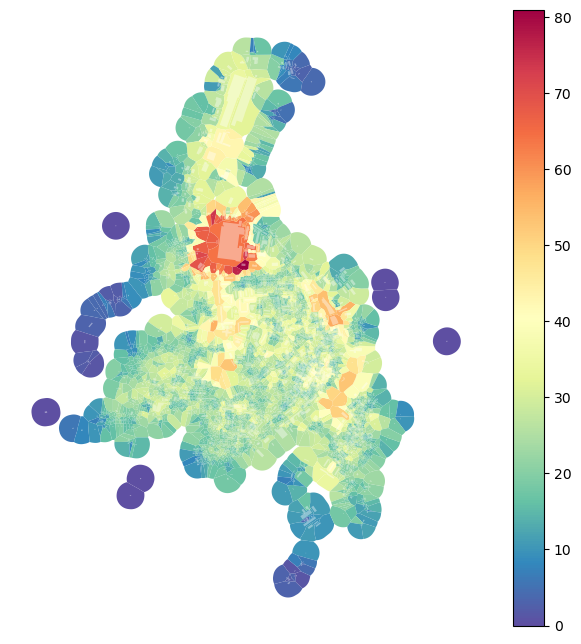

In [17]:
ax = tessellation.plot(
    column="neighbours", legend=True, cmap="Spectral_r", figsize=(8, 8)
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

While `momepy.neighbors` is equal to `contiguity_k3.cardinalities`, the function allows computing a number of neighbors relative to the perimeter of each geometry, which provides very different picture.

In [6]:
tessellation["neighbours_weighted"] = momepy.neighbors(
    tessellation, contiguity_k3, weighted=True
)

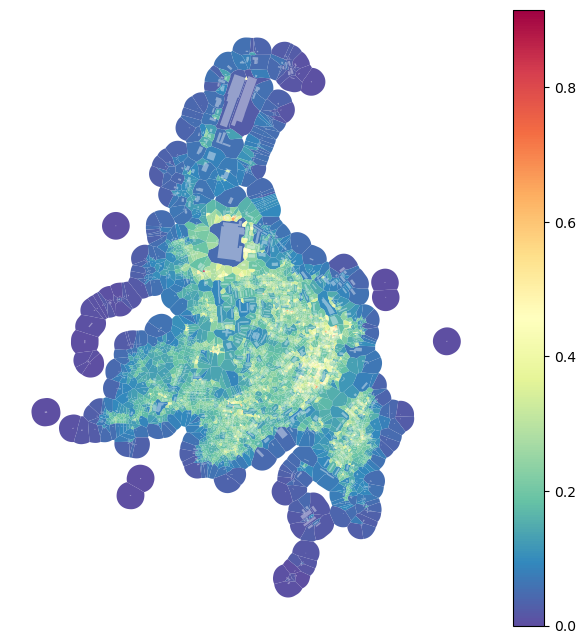

In [18]:
ax = tessellation.plot(
    column="neighbours_weighted", legend=True, cmap="Spectral_r", figsize=(8, 8)
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

## Distance

Often we want to define the neighbours based on metric distance. We will look at two options - distance band and k-nearest neighbour.

### Distance band

We can imagine distance band as a buffer of a set radius around centroid of each object, for example, 400 meters. For that, we can use `Graph.build_distance_band` (note that the builder requires point input - we can use centroid):

In [11]:
dist400 = graph.Graph.build_distance_band(buildings.centroid, threshold=400)
dist400

<Graph of 3014 nodes and 1220242 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

Because the index of buildings and tessellation matches, we can use `dist400` generated on buildings and use it on tessellation:

In [12]:
tessellation["neighbours400"] = momepy.neighbors(tessellation, dist400)

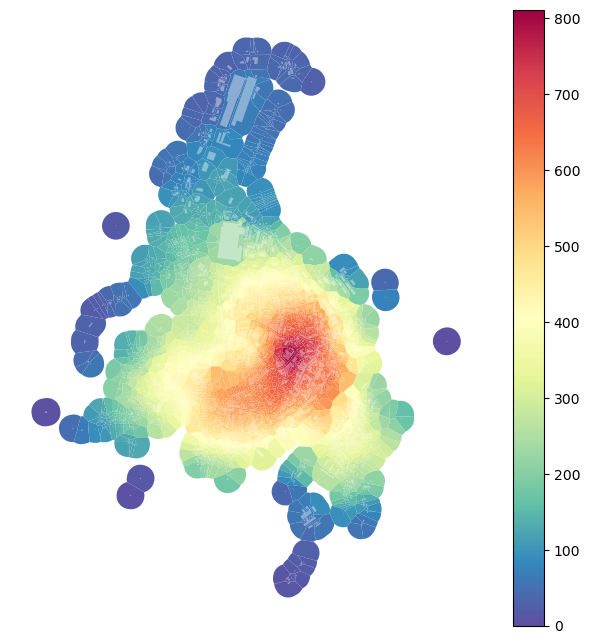

In [19]:
ax = tessellation.plot(
    column="neighbours400", legend=True, cmap="Spectral_r", figsize=(8, 8)
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

### K nearest neighbor

If we want fixed number of neighbours, we can use `Graph.build_knn`:

In [15]:
knn = graph.Graph.build_knn(buildings.centroid, k=200)
tessellation["neighboursKNN"] = momepy.neighbors(tessellation, knn)

**Note**: As all tessellation cells have the same number of neighbours (due to KNN), they all have the same colour.

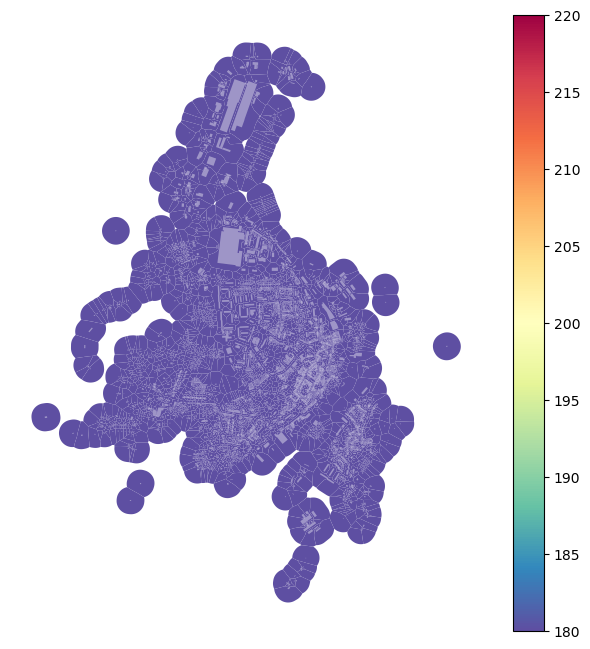

In [21]:
ax = tessellation.plot(
    column="neighboursKNN",
    legend=True,
    cmap="Spectral_r",
    figsize=(8, 8),
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()

All of them can be used within morphometric analysis. Theoretical and practical differences are discussed in Fleischmann, Romice and Porta (2019).

For the other options on generating spatial weights see [lipysal API](https://pysal.org/libpysal/api.html).